# A

In [7]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# from utils import data_read_dict, data_read_concat, data_merge
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot

from benchmark_utils import ts_train_test_normalize


name = 'LSTM_multivariate_EURUSD_1hData'
target = 'EURUSD BGNE Curncy Bid Close'

In [8]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')

In [9]:
# %% read in data and adapt
from utils import data_merge, data_read_dict
def __get_fx_and_metric_data_wo_weekend(
    *,
    pct_change:bool=True,
    dtype:np.float=None,
    directory='data',
    directory_metrics=None,
    sep=',',
    enddate='2022-02-01'
) -> pd.DataFrame:
    """Gets the FX spot rates and combines data with metrics, without missing values on weekends (and bank holidays).

    Args:
        pct_change (bool, optional): Returns percantage change. Defaults to True.
        dtype (numpy.float, optional): data type of data, options 'numpy.floatX'. Defaults to None.

    Returns:
        pd.DataFrame: Spot rates and metrics in one pandas.DataFrame
    """
    path = os.path.join(directory, '10min Dataset Spot.csv')
    df = pd.read_csv(path, delimiter=sep)
    df['Dates'] = pd.to_datetime(df['Dates'], format='%d.%m.%y %H:%M')
    df.set_index('Dates', inplace=True)
    # df = df.asfreq('600S')
    if pct_change:
        df = df.pct_change()[1:]
    # assert len(set(np.diff(df.index.values))) == 1

    FX_Fundamentals_path = os.path.join(directory, '10min Dataset Rest.csv')
    df2 = pd.read_csv(FX_Fundamentals_path, delimiter=sep)
    df2.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
    df2.drop('UXA1 Comdty Trade Open', axis=1, inplace=True)
    df2['Dates'] = pd.to_datetime(df2['Dates'], format='%d.%m.%y %H:%M')
    df2.sort_values('Dates', inplace=True)
    df2.sort_values('Dates')
    df2.index = df2['Dates']

    # df3
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    df3['Dates'] = pd.to_datetime(df3['Dates'], format='%d.%m.%y %H:%M')
    df3.index = df3['Dates']

    df_metrics = data_merge(data_read_dict(os.path.join(directory_metrics, 'bbg')))
    df_metrics.shape
    # excluding eurgbp for now
    df_metrics = df_metrics.loc[:, [i for i in df_metrics.columns if i.split('___')[0].lower() != 'eurgbp']]
#     df_merged = pd.merge(df3, df_metrics, left_index=True, right_index=True, how='outer')
    df_merged = df3.join(df_metrics)
    
    # Deleting all rows that have missing values in df and df2 columns
    df_merged = df_merged.loc[~df_merged.loc[:, set(df.columns.append(df2.columns))].isna().all(axis=1)]

    # Deleting all columns with duplicated data that occur on the weekend
    #(np.diff(df_merged.loc[:, df.columns], prepend=-9999) == 0).mean(axis=1) < 0.95
    duplicates = df_merged.loc[:, df.columns].duplicated()
    weekend = [i.weekday() in [5, 6] for i in df_merged.index]
    # sum(duplicates)
    # sum(weekend)
    # sum(duplicates & weekend)
    # sum(duplicates | weekend)
    df_merged = df_merged.loc[~(duplicates & weekend), :]

    df = df_merged[:]
    df.drop('Dates', axis=1, inplace=True)
    # df = df.asfreq('600S')
    df = df.ffill()
    df = df.loc[(df.index >= '2020-11-01') & (df.index < enddate), :]
    #TODO: There will still be NA values (metric values) in the beginning, possible fixes:
    df = df.bfill()  # back fill
    # df.dropna(how='all', axis=0, inplace=True)  # Drop all rows with NaN values"
    # df.fillna(0, inplace=True)  # impute all NaNs with 0
    df = df.astype(dtype)    
    del df_merged, df2, df3
    return df
df = __get_fx_and_metric_data_wo_weekend(dtype=np.float32, directory='data/1h_Dataset', directory_metrics='data')
# target_column = [i for i in df.columns.tolist() if 'Bid Close' in i]
# target_column_id = [list(df.columns).index(i) for i in target_column]
target_column_id = list(df.columns).index(target)

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


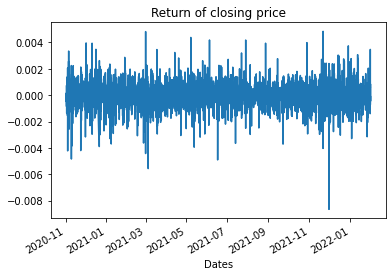

In [10]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [11]:
lag = 128
h = 1
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, target_column_id, dtype=dtype)

In [12]:
def LSTM_model():
    # The LSTM architecture
    act_fct = 'tanh'
    dr = 0.5
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=256, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=256, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=256, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=256, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(Flatten())
    my_LSTM_model.add(Dense(units=1))
    return my_LSTM_model

In [25]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction
def predictions2(my_model, X_test, sc=None, bs=100):
    LSTM_prediction = np.concatenate(
        [my_LSTM_model.predict_on_batch(X_test[i * bs : min((i+1)*bs, X_test.shape[0])]) for i in range(X_test.shape[0] // bs + 1)],
        axis = 0
    )
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [14]:
def earlyStopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
if not os.path.exists('Benchmark/trained_models'):
    os.mkdir('Benchmark/trained_models')
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    'Benchmark/trained_models/%s____{epoch:04}.hdf5'%name,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 50:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001

In [15]:
from tensorflow.keras.optimizers import Adam
my_LSTM_model = LSTM_model()
my_LSTM_model.compile(
    optimizer=Adam(learning_rate=0.05),
    loss='mean_squared_error',
    metrics=[MAE, MAPE]
)

history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
        # earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

Epoch 1/100
199/199 [==============================] - 16s 53ms/step - loss: 2.5932 - mean_absolute_error: 1.2472 - mean_absolute_percentage_error: 5372.7759 - val_loss: 2.0845 - val_mean_absolute_error: 1.0908 - val_mean_absolute_percentage_error: 2326.5400

Epoch 00001: saving model to Benchmark/trained_models/LSTM_multivariate_EURUSD_1hData____0001.hdf5
Epoch 2/100
199/199 [==============================] - 10s 48ms/step - loss: 2.2400 - mean_absolute_error: 1.1370 - mean_absolute_percentage_error: 4040.1238 - val_loss: 1.7226 - val_mean_absolute_error: 0.9108 - val_mean_absolute_percentage_error: 1304.3870

Epoch 00002: saving model to Benchmark/trained_models/LSTM_multivariate_EURUSD_1hData____0002.hdf5
Epoch 3/100
199/199 [==============================] - 10s 50ms/step - loss: 1.7231 - mean_absolute_error: 0.9957 - mean_absolute_percentage_error: 3604.4685 - val_loss: 2.4730 - val_mean_absolute_error: 1.2459 - val_mean_absolute_percentage_error: 2829.4180

Epoch 00003: saving mo

In [16]:
import pickle
with open(f'Benchmark/trained_models/{name}____history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
import pickle
name = 'LSTM_multivariate'
if 'history' not in globals():
    with open(f'Benchmark/trained_models/{name}____history.pkl', 'rb') as f:
        history = pickle.load(f)
if hasattr(history, 'history'):
    history = history.history
if 'my_LSTM_model' not in globals():
    model_last = sorted([i for i in os.listdir('Benchmark/trained_models/') if name + '__' in i and 'hdf5' in i])[-1]
    my_LSTM_model = tf.keras.models.load_model(
        os.path.join('Benchmark/trained_models', model_last)
    )

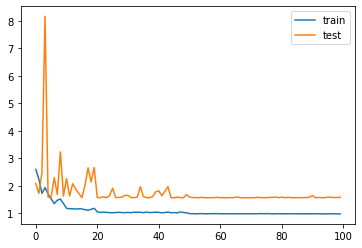

In [18]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
my_LSTM_model.summary()
my_LSTM_model.layers[1].get_weights()[2].dtype

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 256)          1528832   
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 256)          1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 256)          525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 256)          1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 256)          525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 256)          1024      
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 256)          5

dtype('float32')

In [20]:
# opt_learn_rate_plot(
#     my_LSTM_model,
#     X_train,
#     y_train,
#     10**-6,
#     10**-2,
#     100,
#     batch_size=64,
#     steps_per_epoch=1
# )

In [21]:
print('Train')
y = y_train
y_pred = predictions2(
    my_LSTM_model,
    X_train
)
# actual_pred_plot(y_pred[:, 0], y_train[:, 0])
# plt.show()
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

Train
mse: 0.9673017263412476
mae: 0.6757504343986511
mape: 280.472412109375
mde: 0.24175477355215402


Train


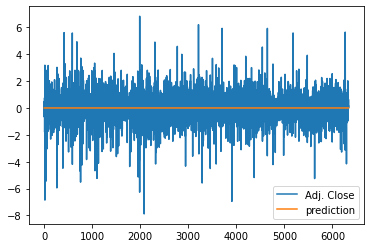

mse: 4.826759436582506e-07
mae: 0.00047734592226333916
mape: 587.080078125
mde: 0.24175477355215402


In [28]:
print('Train')
y = sc_target.inverse_transform(y_train)
y_pred = predictions2(
    my_LSTM_model,
    X_train,
    sc_target
)
actual_pred_plot(y_pred[:, 0], y_train[:, 0])
plt.show()
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

Val


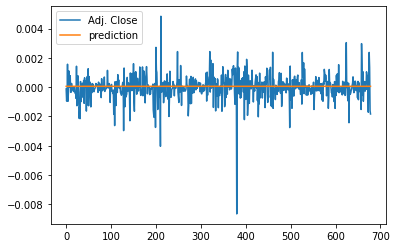

mse: 7.879201007199299e-07
mae: 0.000583483895752579
mape: 607.9102783203125
mde: 0.24778761061946908


In [29]:
print('Val')
y = sc_target.inverse_transform(y_val)
y_pred = predictions2(
    my_LSTM_model,
    X_val,
    sc_target
)
actual_pred_plot(y_pred[:, 0], sc_target.inverse_transform(y_val)[:, 0])
plt.show()
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

Test


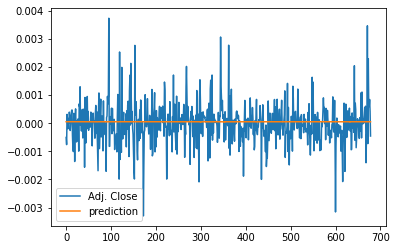

mse: 5.201653721087496e-07
mae: 0.0005028336308896542
mape: 434.8333740234375
mde: 0.2935103244837758


In [30]:
print('Test')
y = sc_target.inverse_transform(y_test)
# y = y_test
y_pred = predictions2(
    my_LSTM_model,
    X_test,
    sc_target
)
actual_pred_plot(y_pred[:, 0], sc_target.inverse_transform(y_test)[:, 0])
plt.show()
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mde: {mde(y.flatten(), y_pred.flatten())}')

In [31]:
epoch = np.argmin(history['val_loss'])
my_LSTM_model = tf.keras.models.load_model(
    os.path.join('Benchmark/trained_models', name + f"____{epoch:04}.hdf5")
)


In [32]:
# X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
test_pred = predictions(
    my_LSTM_model,
    X_test,
    sc_target
)

ValueError: in user code:

    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1579 predict_function  *
        return step_function(self, iterator)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2844 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3619 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1562 run_step  **
        outputs = model.predict_step(data)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1535 predict_step
        return self(x, training=False)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 1238), found shape=(None, 128, 1236)


In [ ]:

fig = plt.figure(figsize=(15,7))
# st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
# st.set_y(0.92)

ax31 = fig.add_subplot(111)
ax31.plot(index_test[lag+1:], y_test[:, 0], label='EURUSD Closing Returns')
ax31.plot(index_test[lag+1:], test_pred, linewidth=3, label='Predicted EURUSD Closing Returns', color='tab:green')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Dates')
ax31.set_ylabel('EURUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)
fig.savefig(os.path.join('Benchmark/trained_models', f"{name}____{epoch:04}_regression.jpg"))

In [ ]:
name